# ENet -  Real Time Semantic Segmentation for Road segmentation

**Journal paper:**<br/>
Link to the paper: https://arxiv.org/pdf/1606.02147.pdf <br/>
**Code references**<br/>
python implementation :https://github.com/iArunava/ENet-Real-Time-Semantic-Segmentation<br/>
lua implemenattion by paper author : https://github.com/e-lab/ENet-training

Daya Alex 5/4/24

In [1]:
!ls /kaggle/usr/lib/metrics-py


__notebook__.ipynb  __output__.json  __results__.html  custom.css  metrics.py


## Wandb login

In [3]:
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Install the dependencies and Import them

In [ ]:
#%pip install pytorch-lightning

In [ ]:
#pip install segmentation_models_pytorch

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
from torchvision import transforms
import math
import random
from torchmetrics import JaccardIndex
import albumentations as A
from torch.utils.data import DataLoader, Dataset
#from segmentation_models_pytorch.losses import DiceLoss

# import sys
# sys.path.append('/kaggle/input/') 
# print(sys.path)
import metrics

from torch.optim.lr_scheduler import StepLR
#import torch.optim.lr_scheduler as lr_scheduler
from PIL import Image
import glob


## Create the ENet model

We decided to to split the model to three sub classes:

1) Initial block  

2) RDDNeck - class for regular, downsampling and dilated bottlenecks

3) ASNeck -  class for asymetric bottlenecks

4) UBNeck - class for upsampling bottlenecks

In [5]:
class InitialBlock(nn.Module):
  
  # Initial block of the model:
  #         Input
  #        /     \
  #       /       \
  # maxpool2d    conv2d-3x3
  #       \       /  
  #        \     /
  #      concatenate
  #          |
  #         Batchnorm
 #        PReLU
   
    def __init__ (self,in_channels = 3,out_channels = 13):
        super().__init__()


        self.maxpool = nn.MaxPool2d(kernel_size=2, 
                                      stride = 2, 
                                      padding = 0)

        self.conv = nn.Conv2d(in_channels, 
                                out_channels,
                                kernel_size = 3,
                                stride = 2, 
                                padding = 1)

        self.prelu = nn.PReLU(16)

        self.batchnorm = nn.BatchNorm2d(16)
  
    def forward(self, x):
        
        main = self.conv(x)
        side = self.maxpool(x)
        #print('main size ', main.size)
        #print('side size ', side.size)
        # concatenating on the channels axis
        x = torch.cat((main, side), dim=1)
        x = self.batchnorm(x)
        x = self.prelu(x)
        #print('init block size ',x.shape)
        
        return x

In [6]:
class RDDNeck(nn.Module):
    def __init__(self, dilation, in_channels, out_channels, down_flag, relu=False, projection_ratio=4, p=0.1):
    
  # Regular|Dilated|Downsampling bottlenecks:
  #
  #     Bottleneck Input
  #        /        \
  #     Identity     \  
  #       /          \
  # maxpooling2d   conv2d-1x1(when downsamp flag is ON, otherwise 2x2)
  # (when downsamp)    | BN +PReLU
  # (-flag is ON)    conv2d-3x3
  #      |             | BN +PReLU
  #      |         conv2d-1x1
  #      |             |
  #  Padding2d     Regularizer(BN + dropout)
  #(when i/p ch !=o/p ch) /   
  #        \            /
  #      Summing + PReLU
  #
  # Params: 
  #  dilation (bool) - if True: creating dilation bottleneck
  #  down_flag (bool) - if True: creating downsampling bottleneck
  #  projection_ratio - ratio between input and output channels
  #  relu - if True: relu used as the activation function else: Prelu us used
  #  p - dropout ratio
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(out_channels // projection_ratio)
        self.out_channels = out_channels
        self.dilation = dilation
        self.down_flag = down_flag
        
        # calculating the number of reduced channels
        if self.down_flag:
            self.stride = 2
            self.conv1_kernel = 2
        else:
            self.stride = 1
            self.conv1_kernel = 1
        
        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2,
                                      stride = 2,
                                      padding = 0, return_indices=True)
        
        self.dropout = nn.Dropout2d(p=p)

        self.prelu1 = activation
        
        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = self.conv1_kernel,
                               stride = self.stride,
                               padding = 0,
                               bias = False,
                               dilation = 1)
        
        self.conv2 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = 1,
                                  padding = self.dilation,
                                  bias = True,
                                  dilation = self.dilation)
                                  
        self.prelu2 = activation
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False,
                                  dilation = 1)
        
        self.prelu3 = activation
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        self.identity = nn.Identity()
        
    def forward(self, x):
        
        bs = x.size()[0]
        x_copy = self.identity(x)
        
        # Main
        x = self.conv1(x)
        #print(" Conv1 called ")
        x = self.batchnorm(x)
        x = self.prelu1(x)
        #print(self.conv1_kernel, self.stride, x.shape)
        
        x = self.conv2(x)
        #print(" Conv2 called ")
        x = self.batchnorm(x)
        x = self.prelu2(x)
        #print(self.conv2.kernel_size, self.stride,self.dilation, x.shape)
        
        x = self.conv3(x)
        #print(" Conv3 called ")
        x = self.batchnorm2(x)     
        x = self.dropout(x)
        #print(self.conv3.kernel_size, self.stride, x.shape)
        
        #other
        if self.down_flag:
            #print('downsampling flag is true')
            x_copy, indices = self.maxpool(x_copy)
            
          
        if self.in_channels != self.out_channels:
            #print('input and output channels diffrence, so padding of side channel being carried out')
            out_shape = self.out_channels - self.in_channels
            #print('extra channels required ', out_shape)
            
            #padding and concatenating in order to match the channels axis of the side and main branches
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available():
                extras = extras.cuda()
            #elif torch.backends.mps.is_available():
                #extras = extras.to('mps')
            #print('x copy shape ',x_copy.shape)
            #print('extras shape ', extras.shape)
            x_copy = torch.cat((x_copy, extras), dim = 1)
            #print('final side route shape ,', x_copy.shape)

        # Summing main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        #print('final layer ', x.shape)
        
        if self.down_flag:
            return x, indices
        else:
            return x

In [7]:
class ASNeck(nn.Module):
    def __init__(self, in_channels, out_channels, projection_ratio=4):
      
  # Asymetric bottleneck:
  #
  #     Bottleneck Input
  #        /        \
  #       /          \
  #      |         conv2d-1x1
  # Identity           | PReLU
  #      |         conv2d-1x5
  #      |             |
  #      |         conv2d-5x1
  #      |             | PReLU
  #      |         conv2d-1x1
  #      |             |
  #       \     Regularizer
  #       \           /  
  #        \         /
  #      Summing + PReLU
  #
  # Params:    
  #  projection_ratio - ratio between input and output channels
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(out_channels // projection_ratio)
        self.out_channels = out_channels
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False)
        
        self.prelu1 = nn.PReLU()
        
        self.conv21 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (5, 1),
                                  stride = 1,
                                  padding = (2, 0),
                                  bias = False)
        
        self.conv22 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (1, 5),
                                  stride = 1,
                                  padding = (0, 2),
                                  bias = True)############TRUE bias in original code###############
        
        self.prelu2 = nn.PReLU()
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = nn.PReLU()
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        self.identity = nn.Identity()
        
    def forward(self, x):
   
        #main branch
        x_copy = self.identity(x)
        #print('side branch')
        
        # Side Branch
        x = self.conv1(x)
        #print('conv1 called')
        x = self.batchnorm(x)
        x = self.prelu1(x)
        #print(self.conv1.kernel_size,self.conv1.stride, x.shape)
        
        x = self.conv21(x)
        #print('conv21 called')
        #print(self.conv21.kernel_size, self.conv21.stride, x.shape)
        x = self.conv22(x)
        #print('conv22 called')
        #print(self.conv22.kernel_size, self.conv22.stride, x.shape)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
        #print('conv3 called')   
        x = self.dropout(x)
        x = self.batchnorm2(x)
        #print('final main ',self.conv3.kernel_size,self.conv3.stride, x.shape)

        # Summing main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        #print('final total ', x.shape)
        
        return x

In [ ]:
class loss_function(nn.Module):
    def __init__(self, class_weights):
        super().__init__()

        self.register_buffer('cls_wts', class_weights)
        self.criterion = nn.CrossEntropyLoss(weight = self.cls_wts)

    def forward(self, out, target):
        loss = self.criterion(out, target)
        return loss



In [8]:
class ENetEncoder(pl.LightningModule):
  
  # Creating Enet model!
  
    def __init__(self, C):
        super().__init__()
        
        # Define class variables
        # C - number of classes
        self.C = C
        class_weights = get_wts()
        self.loss_function = loss_function(class_weights)
        self.tp, self.fp, self.fn, self.tn = [0] *4

        # The initial block
        self.init = InitialBlock()
       
        # The first bottleneck
        self.b10 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=64, 
                           down_flag=True, 
                           p=0.01)
        
        self.b11 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b12 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b13 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b14 = RDDNeck(dilation=1,
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        
        # The second bottleneck
        self.b20 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=128, 
                           down_flag=True)
        
        self.b21 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b22 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b23 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b24 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b25 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b26 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b27 = ASNeck(in_channels=128, 
                          out_channels=128)
        self.b28 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        
        # The third bottleneck
        self.b31 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b32 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b33 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b34 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b35 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b36 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b37 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b38 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        #fully convolutional layer to get the encoder output
        self.enc_conv = nn.Conv2d(in_channels=128,
                                 out_channels = 12,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0,
                                 bias =False)
    def forward(self, x):
        
        # The initial block
        x = self.init(x)
        #print('^^^^^^^^^^^^^^init block^^^^^^^^^^^^^^^^')
        
        # The first bottleneck
        x, i1 = self.b10(x)
        #print('................bottleneck_10 complete................')
        x = self.b11(x)
        #print('................bottleneck_11 complete...........')
        x = self.b12(x)
        #print('...............bottleneck_12 complete............')
        x = self.b13(x)
        #print('............bottleneck_13 complete............')
        x = self.b14(x)
        #print('.................bottleneck_14 complete.............')
        
        # The second bottleneck
        x, i2 = self.b20(x)
        #print('----------------bottleneck_20 complete-----------')
        x = self.b21(x)
        #print('----------------bottleneck_21 complete-----------')
        x = self.b22(x)
        #print('-----------bottleneck_22 complete--------------')
        x = self.b23(x)
        #print('-----------bottleneck_23 complete---------------')
        x = self.b24(x)
        #print('--------------bottleneck_24 complete------------')
        x = self.b25(x)
        #print('-------------bottleneck_25 complete------------')
        x = self.b26(x)
        #print('-------------bottleneck_26 complete-------------')
        x = self.b27(x)
        #print('-------------bottleneck_27 complete-------------')
        x = self.b28(x)
        #print('------------bottleneck_28 complete----------------')
        
        # The third bottleneck
        x = self.b31(x)
        #print('********bottleneck_31 complete************')
        x = self.b32(x)
        #print('********bottleneck_32 complete************')
        x = self.b33(x)
        #print('********bottleneck_33 complete************')
        x = self.b34(x)
        #print('********bottleneck_34 complete************')
        x = self.b35(x)
        #print('********bottleneck_35 complete************')
        x = self.b36(x)
        #print('********bottleneck_36 complete************')
        x = self.b37(x)
        #print('********bottleneck_37 complete************')
        x = self.b38(x)
        #print('********bottleneck_38 complete************')
        
        x = self.enc_conv(x)
        
        return x
    
    def configure_optimizer(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = 5e-4, weight_decay = 2e-4)
        scheduler = StepLR(optimizer, step_size = 100, gamma = 0.1 )
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    def training_step(self, batch, batch_idx):
      
        X_batch, mask_batch = batch
        out = self(X_batch.float()) 
        train_loss = self.loss(out, mask_batch.long())

        self.log('train/loss', train_loss)
        return train_loss

     
    def validation_step(self, batch, batch_idx):
        X_batch, mask_batch = batch
        out = self(X_batch.float())
        val_loss = self.loss(out, mask_batch.long())

        _, predicted_classes = torch.max(outputs, dim = 1)# to get the id of the channel having largest prob (argmax of prob) 
        this_tp, this_fp, this_fn, this_tn = metrics.get_stats(
                                              predicted_classes, mask_batch.long(), mode = "multiclass", num_class= 12
        )

        self.tp += this_tp 
        self.fp += this_fp 
        self.fn += this_fn 
        self.tn += this_tn 
             
        self.log('val/loss', val_loss) 
        return val_loss
        
    def on_validation_epoch_end(self):
        miou_score = metrics.iou_scoreself.miou(sum(self.tp), sum(self.fp), sum(self.fn), sum(self.tn), reduction = 'micro')
        self.log('val/val_accuracy', miou_score )
        self.tp, self.fp, self.fn, self.tn  = [0] * 4
      

## Instantiate the ENet model

Move the model to cuda if available

In [9]:
# Checking if there is any gpu available and pass the model to gpu or cpu

encoder = ENetEncoder(12)

ENet_encoder(
  (init): InitialBlock(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (prelu): PReLU(num_parameters=16)
    (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (b10): RDDNeck(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout2d(p=0.01, inplace=False)
    (prelu1): PReLU(num_parameters=1)
    (conv1): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (prelu2): PReLU(num_parameters=1)
    (conv3): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (prelu3): PReLU(num_parameters=1)
    (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

## visualising pipe

In [11]:
def verify_dataset_normalization(loader,h=360,w=480):
    """finds mean and std dev for whole data batch
    """
    # Initialize accumulators
    channel_sum = torch.tensor([0.0, 0.0, 0.0])
    channel_squared_sum = torch.tensor([0.0, 0.0, 0.0])
    num_batches = 0

    for images, _ in train_loader:
        #print(images.shape)
        # Accumulate sum and squared sum for each channel
        channel_sum += images.sum(dim=[0, 2, 3])
        channel_squared_sum += (images ** 2).sum(dim=[0, 2, 3])
        num_batches += images.shape[0]

    # Calculate mean and standard deviation
    mean = channel_sum / (num_batches * h * w)
    std = (channel_squared_sum / (num_batches * h * w) - mean ** 2) ** 0.5

    return mean, std

In [12]:
def augmentation(mode='train', h= 360, w =480):
    """ resizes image to input size and mask to a downsampled size, 
        applies horizontal flip and color jitter augmentation only to trainsets
        
    """
    if mode == 'train':
        img_transformation = A.Compose([
                        A.Resize(h,w),
                        A.HorizontalFlip(p= 0.5),
                        #A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

                    ])
        #mask size different from image size
        mask_transformation = A.Compose([
                    A.Resize(h//8, w//8),
                    A.HorizontalFlip(p=0.5)
                    ])
        
    else:
        img_transformation =A.Resize(h, w)
        mask_transformation = A.Resize(h//8, w//8)
        
    return img_transformation,  mask_transformation

In [13]:
class CamvidDataset(Dataset):
    """custom camvid datset that returns images and the corresponding masks after augmentation and normalisation  
        
    """
    def __init__(self, img_path, mask_path, augmentation, norm_transform=True, road_idx=None):
        self.filenames_t = os.listdir(img_path)
        self.img_path = img_path
        self.mask_path = mask_path
        self.norm_transform = norm_transform
        self.augmentation = augmentation
        #for exttracting road mask
        #self.road_idx = road_idx 

    def __len__(self):
        return len(self.filenames_t)

    def __getitem__(self, idx):
        each_img_path = os.path.join(self.img_path, self.filenames_t[idx])
        each_mask_path = os.path.join(self.mask_path, self.filenames_t[idx])
        
#         img = cv2.imread(each_img_path, cv2.COLOR_BGR2RGB)
        img = cv2.imread(each_img_path, cv2.IMREAD_COLOR)  # Load the image in BGR color space
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)         # Convert from BGR to RGB

        label_array = cv2.imread(each_mask_path, cv2.IMREAD_GRAYSCALE)#h,w array datatype
        label = np.expand_dims(label_array, axis = -1)#h,w,c
        
        if self.augmentation:
            img_transforms, mask_transforms = self.augmentation
            seed = 7
            random.seed(seed)
            img = img_transforms(image=img)['image']# albumentations must be passed with named argument, and gets stored with that name as key
            random.seed(seed)
            mask = mask_transforms(image=label)['image']
            
        if self.norm_transform:
            normalize_tensor = transforms.Compose([
                            transforms.ToTensor(),
                                     ])
            img = normalize_tensor(img)
            
        if not isinstance(mask, torch.Tensor):
            mask = torch.tensor(mask, dtype=torch.uint8)
        mask = mask.permute(2, 0, 1)#c,h,w
        #print(mask.shape)
        mask = mask.squeeze()#h,w
        #print(mask.shape)
        return img, mask


In [ ]:
class camvid_lite(pl.LightningDataModule):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size

        def setup(self, stage =None):#stage none means 
            self.train_aug = augmentation('train')
            self.val_aug = augmentation('val')
            train_dataset = CamvidDataset('/teamspace/uploads/CamVid/train','/teamspace/uploads/CamVid/trainannot', self.train_aug)
            val_dataset = CamvidDataset('/teamspace/uploads/CamVid/val','/teamspace/uploads/CamVid/valannot', self.val_aug)

        def train_dataloader(self):
            return DataLoader(train_dataset, self.batch_size, shuffle=True)

        def val_dataloader(self):
            return DataLoader(val_dataset, self.batch_size, shuffle=False)
        #TO DO: testset preparation


In [ ]:
datamod = camvid_lite(config.batch_size)
datamod.setup()

In [ ]:
trainer = pl.Trainer( logger = WandbLogger,
                        max_epochs = config.epochs)

trainer.fit(encoder, datamod)

In [ ]:
class Idd7ClassesDataset(Dataset):
    def __init__(self, img_path, mask_path, augmentation, norm_transform=True, road_idx=None):
        self.filenames_t = glob.glob(training_path+f'*\*.jpg')
        self.filenames_s = glob.glob(segmented_path+f'*\*[0-9]_label.png')
        self.norm_transform = norm_transform
        self.dual_transform = dual_transform
        self.road_idx = road_idx

    def __len__(self):
        return len(self.filenames_t)

    def __getitem__(self, idx):
        img_path = self.filenames_t[idx]
        mask_path = self.filenames_s[idx]
        img = cv2.imread(each_img_path, cv2.COLOR_BGR2RGB)
        label_array = cv2.imread(each_mask_path, cv2.IMREAD_GRAYSCALE)#h,w array datatype
        label = np.expand_dims(label_array, axis = -1)#h,w,c
        
        if self.augmentation:
            img_transforms, mask_transforms = self.augmentation
            seed = 7
            random.seed(seed)
            img = img_transforms(image=img)['image']# albumentations must be passed with named argument, and gets stored with that name as key
            random.seed(seed)
            mask = mask_transforms(image=label)['image']
            
        if self.norm_transform:
            normalize_tensor = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.3576, 0.3713, 0.3657], 
                                                [0.2608, 0.2723, 0.2943])
                                     ])
            img = normalize_tensor(img)
            
        if not isinstance(mask, torch.Tensor):
            mask = torch.tensor(mask, dtype=torch.uint8)
        mask = mask.permute(2, 0, 1)#c,h,w
        #print(mask.shape)
        mask = mask.squeeze()#h,w
        #print(mask.shape)

        return img, mask


In [ ]:

# train_dataset = Idd7ClassesDataset("/kaggle/input/idd-lite1-6k/idd20k_lite/leftImg8bit/train/",
#                                     "/kaggle/input/idd-lite1-6k/idd20k_lite/gtFine/train/", augmentation('train'))
# val_dataset = Idd7ClassesDataset("/kaggle/input/idd-lite1-6k/idd20k_lite/leftImg8bit/val/",
#                                     "/kaggle/input/idd-lite1-6k/idd20k_lite/gtFine/val/",augmentation('val'))


test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False) 
    
mean_train, std_train = verify_dataset_normalization(train_loader)
mean_val, std_val = verify_dataset_normalization(val_loader)
# mean_test, std_test = verify_dataset_normalization(test_loader)

print(f'mean and std dev of train set is {mean_train}, {std_train}')
print(f'mean and std dev of val set is {mean_val}, {std_val}')
# print(f'mean and std dev of test set is {mean_test}, {std_test}')


In [15]:
def get_wts(dataset):
    loader = DataLoader(dataset, batch_size=1, shuffle=True)

    hist = torch.zeros(12)
    for batch in tqdm(loader):
        _, mask = batch
        #print(mask.shape)
        mask = mask.squeeze(0).float()
        #print(mask.shape)

        hist += torch.histc(mask, 12, 0,11 )

    norm_hist = hist/torch.sum(hist)

    class_wts = torch.ones(12)
    for idx in range(12):
        if hist[idx]<1 or idx ==11:
            class_wts[idx] = 0
        else:
            class_wts[idx] = 1/torch.log(1.02 + norm_hist[idx])

    return class_wts

tr_weights = get_wts(train_dataset)
vl_weights = get_wts(val_dataset)
print('class wts of train ', tr_weights)
print('class wts of val ', vl_weights)



100%|██████████| 101/101 [00:02<00:00, 35.09it/s]

class wts of train  tensor([ 6.0922,  4.4581, 34.0328,  3.3760, 14.6258,  9.3756, 28.3469, 29.9506,
        13.2160, 37.3547, 41.8958,  0.0000])
class wts of val  tensor([ 9.6918,  4.1043, 38.3203,  3.6792,  9.5460,  5.9751, 31.9145, 19.8609,
        26.2329, 37.0381, 24.7237,  0.0000])


In [16]:
def decode_segmap(image, threshold=0.5):
    
    #print(image)#RGB
    Sky = [0, 0, 0]
    Building = [0, 0, 153]
    Pole = [0, 0, 255]
    Road = [51, 153, 255]
    Pavement = [0, 255, 255]
    Tree = [128, 255, 0]
    SignSymbol = [255, 255, 0]
    Fence = [64, 64, 128]
    Car = [255, 128, 0]
    Pedestrian = [255, 0, 127]
    Bicyclist = [255, 204, 255]
    Background_scene = [255,255,255]

    label_colours = np.array([Sky, Building, Pole, Road, 
                              Pavement, Tree, SignSymbol, Fence, Car, 
                              Pedestrian, Bicyclist, Background_scene]).astype(np.uint8)
    
    #print(label_colours.shape)
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    
    for l in range(0, 12):
        r[image == l] = label_colours[l, 0]
        g[image == l] = label_colours[l, 1]
        b[image == l] = label_colours[l, 2]

    rgb = np.zeros((image.shape[0], image.shape[1], 3)).astype(np.uint8)
    rgb[:, :, 0] = r
    rgb[:, :, 1] = g
    rgb[:, :, 2] = b
    return rgb


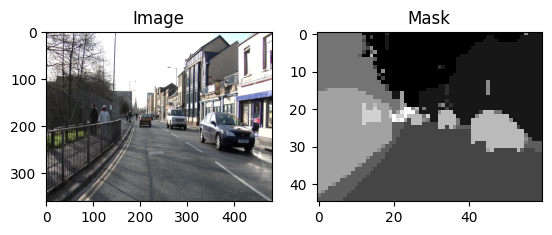

In [17]:
import matplotlib.pyplot as plt

def visualize_sample(dataset, idx):
    img, mask = dataset[idx]  # Fetch the image and mask using the dataset's __getitem__ method
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img.permute(1, 2, 0))  # Assuming img is a PyTorch tensor of shape [C, H, W]
    ax[0].set_title("Image")
    ax[1].imshow(mask, cmap='gray')  # Assuming mask is a PyTorch tensor of shape [C, H, W] and C=1 for grayscale
    ax[1].set_title("Mask")
    plt.show()

# Example usage
visualize_sample(train_dataset, 5)  # Visualize the first sample in the train dataset


torch.Size([3, 360, 480]) torch.Size([45, 60])


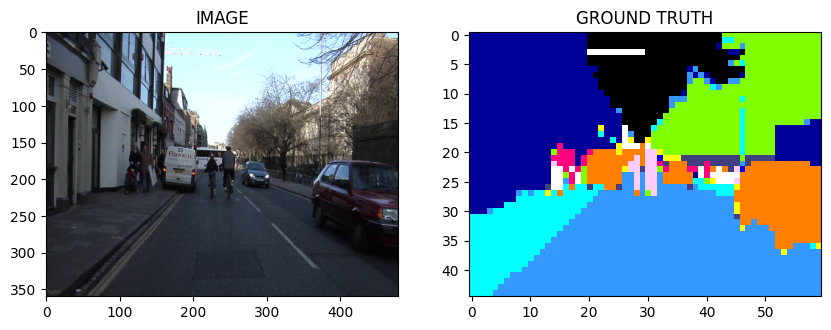

In [18]:
idx = 0

img, mask = train_dataset[idx]
print(img.shape, mask.shape)
#print(mask)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(img.permute(1,2,0).squeeze())
        
ax2.set_title('GROUND TRUTH')
ax2.imshow(mask.squeeze(),cmap = 'gray')
mask_segmap =decode_segmap(mask.squeeze().numpy())

ax2.imshow(mask_segmap)

## Define the Hyperparameters

## Training loop

In [19]:

# bc_train = 367 // batch_size # count of mini_batch train
# bc_eval = 101 // batch_size  # count of mini_batch validation
# bc_test = 233 // batch_size

# epochs = 20
# save_every = 200
total_run :int = 1

In [43]:
def log_image_table(X_batch, outputs, mask_batch, e):
    table = wandb.Table(columns = ["images", "predictions", "targets"] 
            )
    for X_img, output, mask in zip(X_batch.to("cpu"), outputs.to("cpu"), mask_batch.to("cpu")):
        segmap_pred = decode_segmap(output.data.max(0)[1].numpy())#pass the max prob channel
        segmap_gt = decode_segmap(mask.numpy())
        
        table.add_data(wandb.Image(X_img.numpy().transpose(1,2,0)*255), 
                  wandb.Image(segmap_pred), 
                  wandb.Image(segmap_gt)
                 )
    print('inside log table function ')
    wandb.log({f"predictions_table {e}": table}, commit = False) #lets commit to the server with the metrics

In [44]:
def validation_loop(model, val_loader, criterion,e, log_images = False, batch_idx = 0):
    """ params: model, val_loader,loss function, 
        flag log_images: to decide to log the predictions in table
        flag batch_idx : to log a single batch consistently over all epochs, default 0th batch, 
        
        returns validation loss and accuracy averaged for that epoch """
    print(e)
    model.eval()
    val_loss = 0
    tp, fp, fn, tn = [0] *4
    with torch.inference_mode():
        cum_jacc = 0
        for step, (X_batch, mask_batch)in enumerate(val_loader):
            
            X_batch, mask_batch = X_batch.to(device), mask_batch.to(device)
            outputs,_,_ = model(X_batch.float())
            val_loss += criterion(outputs, mask_batch.long())* X_batch.size(0)
            _, predicted_classes = torch.max(outputs, dim=1)# we will get channel number corresponding to highest prob at each pixel
            
            #print(predicted_classes.shape)
            
            this_tp, this_fp, this_fn, this_tn = metrics.get_stats(
                predicted_classes, mask_batch.long(), mode = "multiclass", num_classes= 12
                                                                    )
            tp += this_tp
            fp += this_fp
            fn += this_fn
            tn += this_tn     
            if step == batch_idx and log_images:
                log_image_table(X_batch, outputs, mask_batch, e)

        iou_score = metrics.iou_score(sum(tp), sum(fp), sum(fn), sum(tn), reduction = 'micro')
        return val_loss/len(val_loader.dataset), iou_score
            
        

In [22]:
for run in range(total_run):
    config ={"learning_rate": 5e-4,
                        "batch_size": 10,
                        "epochs": 1200,
                       } 
    wandb.init(project ='CAMVID,ENET ENCODER',
                name=f'changed cv2imread, same class weights lr={config["learning_rate"]}_bs={config["batch_size"]}_epochs={config["epochs"]}',
               config=config)

    config = wandb.config
    
    val_error = 10e4
    train_loader = DataLoader(train_dataset, config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, config.batch_size , shuffle=False)
    test_loader = DataLoader(test_dataset, config.batch_size , shuffle=False) 
    
    n_steps_per_epoch = math.ceil(len(train_dataset)/config.batch_size)
    model = encoder
    tr_criterion = nn.CrossEntropyLoss(weight = tr_weights.to(device))
    #vl_criterion = nn.CrossEntropyLoss(weight = vl_weights.to(device))
    optimizer = torch.optim.Adam(encoder.parameters(), 
                             lr=config.learning_rate,
                             weight_decay=2e-4)
    
    
    model.to(device)
    element_step_ct = 0
    step_ct = 0
    for e in range(config.epochs):
          
        model.train()
    
        for step, (X_batch,mask_batch) in enumerate(train_loader):
            
            # assign data to cpu/gpu
            X_batch, mask_batch = X_batch.to(device), mask_batch.to(device) 
            out,i1,i2 = model(X_batch.float())

            optimizer.zero_grad()
            train_loss = tr_criterion(out, mask_batch.long())
            
            # update weights
            train_loss.backward()
            optimizer.step()
            element_step_ct += len(X_batch)
            
            train_metrics = {"train/loss": train_loss,#loss per batch
                       "train/epoch": (step +1 +(n_steps_per_epoch*e))/n_steps_per_epoch,
                       "train:element_step_ct":element_step_ct
                      }
            if step+1<n_steps_per_epoch:
                wandb.log(train_metrics)
            
            step_ct +=1
        
        val_loss, jacc_acc = validation_loop(model, val_loader, tr_criterion,e, (e== config.epochs -1)) 
        val_metrics = {"val/val_loss": val_loss,
                      "val/val_accuracy": jacc_acc}
        
        ##logging val metrics alongside train metrics
        wandb.log({**train_metrics, **val_metrics })
        
        #print final achieved losses and accuracy at the end of each epoch
        print(f"Train loss: {train_loss:.3f},Valid_loss: {val_loss:.3f},Accuracy: {jacc_acc:.2f}")
        
        if val_loss < val_error:
            checkpoint = {
            'epochs' : e,
            'state_dict' : model.state_dict(),
            'maxpool_indices_1':i1,
            'maxpool_indices_2':i2,
            'jacc':jacc_acc,
            }
            torch.save(checkpoint, './encoder camvid {}th epoch, indices with state_dic.pth'.format(e))
            #wandb.log_artifact()
            print ('Model is saved!')
            val_error = val_loss
            
wandb.finish()

wandb: Currently logged in as: dayaalex. Use `wandb login --relogin` to force relogin


Train loss: 1.434,Valid_loss: 2.123,Accuracy: 0.18
Model is saved!
Train loss: 1.221,Valid_loss: 2.073,Accuracy: 0.12
Model is saved!
Train loss: 1.183,Valid_loss: 2.072,Accuracy: 0.08
Model is saved!
Train loss: 1.202,Valid_loss: 2.027,Accuracy: 0.10
Model is saved!
Train loss: 1.086,Valid_loss: 2.045,Accuracy: 0.10
Train loss: 0.847,Valid_loss: 2.019,Accuracy: 0.10
Model is saved!
Train loss: 0.943,Valid_loss: 2.032,Accuracy: 0.10
Train loss: 0.905,Valid_loss: 2.003,Accuracy: 0.11
Model is saved!
Train loss: 0.725,Valid_loss: 1.933,Accuracy: 0.13
Model is saved!
Train loss: 0.689,Valid_loss: 1.961,Accuracy: 0.12
Train loss: 0.698,Valid_loss: 2.002,Accuracy: 0.10
Train loss: 0.890,Valid_loss: 1.889,Accuracy: 0.17
Model is saved!
Train loss: 0.659,Valid_loss: 1.959,Accuracy: 0.12
Train loss: 0.668,Valid_loss: 1.963,Accuracy: 0.14
Train loss: 0.594,Valid_loss: 1.933,Accuracy: 0.18
Train loss: 0.648,Valid_loss: 1.932,Accuracy: 0.19
Train loss: 0.694,Valid_loss: 1.917,Accuracy: 0.16
Train

train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/loss,█▅▅▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train:element_step_ct,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val/val_accuracy,▃▄▄▃▃▃▃▃▄▃▂▂▁▂▅▃▂▂▃▄▅▂▆▅▇▆▆▆▆▅▆▅▅▆▂▇██▅▅
val/val_loss,▁▁▃▅▅▆▇▅▆▇▇▆▇▇▄▆▇█▇▇▇▆▅▆▃▅▅▆▄▇▆▇▆▅▆▄▄▄▅▇
train/epoch,1200.0
train/loss,0.06732
train:element_step_ct,440400
val/val_accuracy,0.24454
val/val_loss,3.01153


In [34]:
print(e)

1199


In [45]:
# checkpoint = {
# 'epochs' : e,
# 'state_dict' : model.state_dict(),
# 'maxpool_indices_1':i1,
# 'maxpool_indices_2':i2,
# 'jacc':jacc_acc,
# }
# torch.save(checkpoint, './encoder camvid {}th epoch, indices with state_dic.pth'.format(e))
# #wandb.log_artifact()
# torch.save(checkpoint, './encoder camvid {}th epoch, indices with state_dic.pth'.format(e))
 
wandb.init(project ='CAMVID,ENET ENCODER',
            name=f'plotting 1199 epoch mask',
           )
        
val_loss, jacc_acc = validation_loop(model, val_loader, tr_criterion,e, (e== 1199)) 
val_metrics = {"val/val_loss": val_loss,
                      "val/val_accuracy": jacc_acc}
        
wandb.log(val_metrics)


val/val_accuracy,▁
val/val_loss,▁
val/val_accuracy,0.24454
val/val_loss,3.01153


1199
inside log table function 


## Infer using the trained model

In [35]:
def show_images(images, in_row=True):
    '''
    Helper function to show 3 images
    '''
    total_images = len(images)

    rc_tuple = (1, total_images)
    if not in_row:
        rc_tuple = (total_images, 1)
    
    #figure = plt.figure(figsize=(20, 10))
    for ii in range(len(images)):
        plt.subplot(*rc_tuple, ii+1)
        plt.title(images[ii][0])
        plt.axis('off')
        plt.imshow(images[ii][1])
    plt.show()

In [36]:
checkpoint = torch.load('/kaggle/working/encoder camvid 1199th epoch, indices with state_dic.pth')
enc = ENet_encoder(12)
enc = enc.to(device)
state_dict = checkpoint['state_dict']
enc.load_state_dict(state_dict)

<All keys matched successfully>

/tmp/ipykernel_34/3695398114.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(*rc_tuple, ii+1)


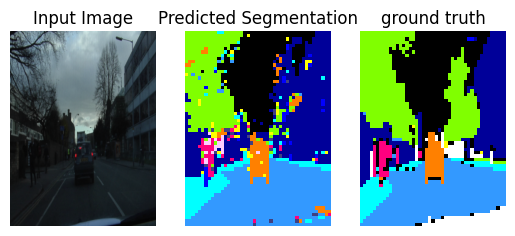

In [52]:
h = 360
w = 480

image_path = '/kaggle/input/camvid-seg-12/CamVid/test/0001TP_008730.png'
# Assuming the dataset is camvid

tmg_ = plt.imread(image_path)
tmg_ = cv2.resize(tmg_, (h, w), cv2.INTER_NEAREST)
tmg = torch.tensor(tmg_).unsqueeze(0).float()
tmg = tmg.transpose(2, 3).transpose(1, 2)
tmg = tmg.to(device)

with torch.no_grad():
    out1, id1, id2 = enc(tmg.float())
    out1 = out1.squeeze(0)
b_ = out1.data.max(0)[1].cpu().numpy()

decoded_segmap = decode_segmap(b_)

gt_path = image_path.replace('test','testannot') 
gt = plt.imread(gt_path)
gt = cv2.resize(gt, (h//8, w//8), cv2.INTER_NEAREST)
gt = decode_segmap(gt*255)

images = {
 0 : ['Input Image', tmg_],
 1 : ['Predicted Segmentation', decoded_segmap],
 2 : ['ground truth', gt]
}

plt.title('cross_entropy_multi-class_1200_epochs')

show_images(images)


In [53]:
checkpoint = torch.load('/kaggle/working/encoder camvid 24th epoch, indices with state_dic.pth')
enc = ENet_encoder(12)
enc = enc.to(device)
state_dict = checkpoint['state_dict']
enc.load_state_dict(state_dict)

<All keys matched successfully>

/tmp/ipykernel_34/3695398114.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(*rc_tuple, ii+1)


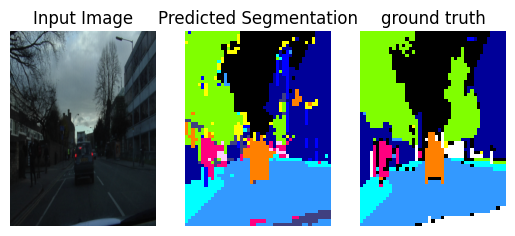

In [54]:
h = 360
w = 480

image_path = '/kaggle/input/camvid-seg-12/CamVid/test/0001TP_008730.png'
# Assuming the dataset is camvid

tmg_ = plt.imread(image_path)
tmg_ = cv2.resize(tmg_, (h, w), cv2.INTER_NEAREST)
tmg = torch.tensor(tmg_).unsqueeze(0).float()
tmg = tmg.transpose(2, 3).transpose(1, 2)
tmg = tmg.to(device)

with torch.no_grad():
    out1, id1, id2 = enc(tmg.float())
    out1 = out1.squeeze(0)
b_ = out1.data.max(0)[1].cpu().numpy()

decoded_segmap = decode_segmap(b_)

gt_path = image_path.replace('test','testannot') 
gt = plt.imread(gt_path)
gt = cv2.resize(gt, (h//8, w//8), cv2.INTER_NEAREST)
gt = decode_segmap(gt*255)

images = {
 0 : ['Input Image', tmg_],
 1 : ['Predicted Segmentation', decoded_segmap],
 2 : ['ground truth', gt]
}

plt.title('cross_entropy_multi-class_24_epochs')

show_images(images)

In [49]:
!pip install torchsummary
from torchsummary import summary

summary(enc, input_size=(3, 360, 480))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 13, 180, 240]             364
         MaxPool2d-2          [-1, 3, 180, 240]               0
       BatchNorm2d-3         [-1, 16, 180, 240]              32
             PReLU-4         [-1, 16, 180, 240]              16
      InitialBlock-5         [-1, 16, 180, 240]               0
          Identity-6         [-1, 16, 180, 240]               0
            Conv2d-7          [-1, 16, 90, 120]           1,024
       BatchNorm2d-8          [-1, 16, 90, 120]              32
             PReLU-9          [-1, 16, 90, 120]               1
           Conv2d-10          [-1, 16, 90, 120]           2,320
      BatchNorm2d-11          [-1, 16, 90, 120]              32
            PReLU-12          [-1, 16, 90, 120]               1
           Conv2d-13          [-1, 64, 90, 120]           1,024
      BatchNorm2d-14          [-1, 64, 

In [ ]:

def test_model(model, epochs,test_loaders, criterion, optimizer,device):
    jacc_t_acc =[]   
    test_losses =[]
    for e in range(1,epochs+1):
        model.to(device)
        with torch.no_grad():
            model.eval()
            
            test_loss = 0
            cum_test_iou =0
            cum_jacc_t = 0
            # Validation loop
            for inputs, labels in tqdm(val_loader):
                
                inputs, labels = inputs.to(device), labels.squeeze(1).to(device)
                    
                out, id1,id2 = model(inputs)
                loss = criterion(out, labels.long())
                test_loss += loss.item()
                preds_ohe = torch.argmax(out, dim=1)
                  
                #cum_test_iou += calculate_mIoU(preds_ohe, labels, 2) 
                target = labels.squeeze(1)         
                cum_jacc_t += jaccard(preds_ohe,target)

        test_losses.append(test_loss/bc_test)
        #test_acc.append(cum_test_iou/batch_size)
        jacc_t_acc.append(cum_jacc_t/bc_test)
        print ('Epoch {}/{}...'.format(e, epochs),
                
                'test_Loss {:6f}'.format(test_losses[-1]),
                #'test_acc {:6f}'.format(test_acc[-1]),
                'jacc_t_acc {:6f}'.format(jacc_t_acc[-1]))
        
    print ('Epoch {}/{}...'.format(e, epochs),
           'Total Mean test loss:{:6f}'.format(sum(test_losses)/epochs))
    return  test_losses, jacc_t_acc
      
      

In [ ]:
test_losses, test_acc = test_model(encoder, epochs,test_loader, criterion, optimizer, device)